In [70]:
import requests
req=requests.get("http://www.ams.jhu.edu/~dan/stock_twits/twits.txt")
txt=req.text
txt.count("\n")

2288

In [71]:
S=txt.split("\n")
len(S)

2289

In [75]:
T=[json.loads(S[i]) for i in range(len(S)-1)]

In [76]:
L=[T[k]['messages'] for k in range(len(T))]

In [78]:
M=[x for y in L for x in y ]

In [79]:
SYMBOL=[T[k]['symbol']['symbol'] for k in range(len(T)) for j in range(30)]

In [80]:
IDnumbers=set([x['id'] for x in M])

In [16]:
IDcount={}
for id in IDnumbers:
    S=[x for x in M if x['id']==id]
    IDcount[str(id)]=len(S)

In [81]:
k=IDcount.keys()

In [84]:
IDloc={}
for k in range(len(M)):
    id=str(M[k]['id'])
    if id in IDloc.keys():
        IDloc[id].append(k)
    else:
        IDloc[id]=[k]

In [85]:
P=[M[IDloc[id][0]] for id in IDloc]
S=[SYMBOL[IDloc[id][0]] for id in IDloc]

In [86]:
followers=[P[k]['user']['followers'] for k in range(len(P))]
following=[P[k]['user']['following'] for k in range(len(P))]

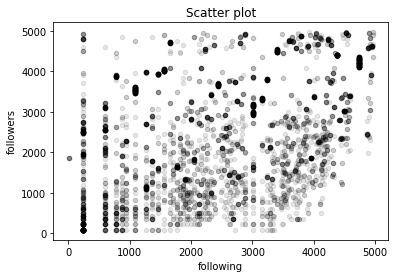

In [88]:
from scipy.stats import rankdata
import matplotlib.pyplot as plt
rfollowers=rankdata(followers)
rfollowing=rankdata(following)
%matplotlib inline 
# Plot
plt.scatter(rfollowing, rfollowers,alpha=.1,s=20,color='black')
plt.title('Scatter plot')
plt.xlabel('following')
plt.ylabel('followers')
plt.show()

In [89]:
import numpy as np
np.corrcoef(rfollowers,rfollowing)

array([[1.        , 0.44514199],
       [0.44514199, 1.        ]])

In [90]:
Sentiments=[P[k]['entities']['sentiment'] for k in range(len(P))]

In [91]:
Sent=[x['basic'] for x in Sentiments if x!=None and 'basic' in x]

In [92]:
def sentiment(p):
    q=p['entities']['sentiment']
    if q==None:
        return(None)
    else:
        if 'basic' in q:
            return(q['basic'])
        else:
            return(None)
    

In [37]:
P=[p for p in P if sentiment(p)!=None]

1391

Randomly set aside 1/3 of the data for testing and use 2/3 for training.

In [94]:
import numpy as np
N=len(P)
Itest=list(np.random.choice(range(N), int(N/3)))
Itrain=[i for i in range(N) if i not in Itest]
Ptrain=[P[i] for i in Itrain]
Ptest=[P[i] for i in Itest]

In [95]:
def listofsymbols(p):
    E=p['symbols']
    symbols=[x['symbol'] for x in E]
    return(symbols)
listofsymbols(Ptrain[2])

['DJIA', 'SPX', 'SPY', 'STUDY']

In [96]:
def nsymbols(p):
    return(len(listofsymbols(p)))

Extract all entities that look like words from body. Also, leave out words that have the word "bull" or "bear" in them.

In [100]:
import re
import nltk
def wordlist(p):
    body=p['body']
    symbols=listofsymbols(p)
    #
    # remove every symbol - note that the list doesn't include the $ symbol.
    # so we need to add it to our expression to substitute.
    # we also need to escape it since it has special meaning as a pattern.
    #
    for s in symbols:
        s=r"\$" + s
        body=re.sub(s," ",body)
    #
    # remove all expressions of the form &xxx; 
    #
    p=r"&\w*?;"
    body=re.sub(p," ",body)
    #
    # remove all non alphabetic characters
    #
    p=r"\W"
    body=re.sub(p," ",body)
    #
    # split on the space characters
    #
    wordlist=body.split()
    #
    # remove any word that has "bear" or "bull" in it
    #
    wordlist=[w for w in wordlist if not re.search("bear",w)]
    wordlist=[w for w in wordlist if not re.search("bull",w)] 
    #
    # remove words with numbers in them
    #
    wordlist=[w for w in wordlist if not re.search("\d",w)]
    #
    # remove duplicates
    #
    wordlist=list(set(wordlist))
    return(wordlist)

Make list of wordlists one for each twit in the training set and list for each twit in the test set.

In [113]:
twit_wordlists_train=[wordlist(p) for p in Ptrain]
twit_wordlists_test=[wordlist(p) for p in Ptest]

Make a list of all words appearing in any twit in the training set.

In [114]:
WORDS_TRAIN=[twit_wordlists_train[k] for k in range(len(Ptrain))]
WORDS_TRAIN=[w for k in range(len(WORDS_TRAIN)) for w in WORDS_TRAIN[k]]
WORDS_TRAIN=list(set(WORDS_TRAIN))

Make an array with features as columns - feature being presence of word in twit.
Each row is a twit. And make a column of indicators of bullish.

Do the same with the test set but note we aren't allowed to look at the test dataset words to create features, so we use the word list from the training set.

In [115]:
import numpy as np
Xtrain=np.zeros((len(Ptrain),len(WORDS_TRAIN)))
Ytrain=np.zeros(len(Ptrain))
for i in range(len(Ptrain)):
    p=Ptrain[i]
    # list of words for the i-th twit
    wlist=twit_wordlists_train[i] 
    for j in range(len(WORDS_TRAIN)):
        w=WORDS_TRAIN[j]
        if w in wlist:
            Xtrain[i,j]=1
    if sentiment(p)=="Bullish":
        Ytrain[i]=1
Xtest=np.zeros((len(Ptest),len(WORDS_TRAIN)))
Ytest=np.zeros(len(Ptest))
for i in range(len(Ptest)):
    p=Ptest[i]
    # list of words for the i-th twit
    wlist=twit_wordlists_test[i] 
    for j in range(len(WORDS_TRAIN)):
        w=WORDS_TRAIN[j]
        if w in wlist:
            Xtest[i,j]=1
    if sentiment(p)=="Bullish":
        Ytest[i]=1

In [116]:
import sklearn.feature_selection
chi2=sklearn.feature_selection.chi2(Xtrain, Ytrain)
pvalues=chi2[1]

In [117]:
sorted([(pvalues[k],WORDS_TRAIN[k]) for k in range(len(WORDS_TRAIN)) if pvalues[k]<.01])

[(2.971275142660756e-38, 'alerted'),
 (1.6425678793308301e-34, 'Calls'),
 (1.6425678793308301e-34, 'Update'),
 (2.294685350649323e-31, 'Up'),
 (3.0528705351962008e-30, 'com'),
 (7.545762602026439e-25, 'https'),
 (1.4840011355873486e-24, 'since'),
 (8.168806458237175e-15, 'www'),
 (1.3023567746204406e-13, 'Jan'),
 (5.159237088719386e-12, 'http'),
 (7.8580913152244e-12, 'php'),
 (1.636190106685361e-11, 'utm_campaign'),
 (1.0671059305423163e-10, 'utm_medium'),
 (1.0810175973655462e-10, 'utm_content'),
 (1.2006927913765832e-10, 'chartmill'),
 (1.2006927913765832e-10, 'social_tracking'),
 (1.622294196192536e-10, 'stocktwits'),
 (2.472140565232286e-10, 'utm_source'),
 (6.010868243445985e-09, 's'),
 (8.289002448207582e-08, 'key'),
 (1.1432317641400034e-07, 'Peak'),
 (1.4085902457063764e-07, 'analyze'),
 (2.6636268302907907e-07, 'r'),
 (7.997090115263792e-07, 'Winners'),
 (1.3367798423157987e-06, 'Losers'),
 (4.97410288863186e-06, 'volume'),
 (5.53292834212834e-06, 'above'),
 (6.54641375096237

In [118]:
indices_of_kept_words=[k for k in range(len(WORDS_TRAIN)) if pvalues[k]<.01]
words_kept=[WORDS_TRAIN[i] for i in indices_of_kept_words]
Xtrain=Xtrain[:,indices_of_kept_words]
Xtest=Xtest[:,indices_of_kept_words]

In [119]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(Xtrain, Ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predict for the test set.

In [120]:
Ypred=clf.predict_proba(Xtest)

In [121]:
def confusion_matrix(Ytrue,Ypred,threshold):
    M=np.zeros((2,2))
    n=len(Ytrue)
    M[0,0]=len([k for k in range(n) if Ytrue[k]==0 and Ypred[k][1]<=threshold])
    M[0,1]=len([k for k in range(n) if Ytrue[k]==0 and Ypred[k][1]>threshold])
    M[1,0]=len([k for k in range(n) if Ytrue[k]==1 and Ypred[k][1]<=threshold])
    M[1,1]=len([k for k in range(n) if Ytrue[k]==1 and Ypred[k][1]>threshold])
    return(M)
    

In [122]:
confusion_matrix(Ytest,Ypred,1)

array([[1349.,    0.],
       [ 305.,    0.]])

Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xtrain,Ytrain)
Ypred=clf.predict_proba(Xtest)

C:\Users\gentl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [124]:
confusion_matrix(Ytest,Ypred,.0)

array([[   0., 1349.],
       [   0.,  305.]])

Decision tree

In [125]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
Ypred=clf.predict_proba(Xtest)
confusion_matrix(Ytest,Ypred,.5)

array([[1305.,   44.],
       [ 270.,   35.]])

Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [127]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=3,random_state=0)
clf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [128]:
Ypred=clf.predict_proba(Xtest)

In [129]:
confusion_matrix(Ytest,Ypred,.7)

array([[1.349e+03, 0.000e+00],
       [3.040e+02, 1.000e+00]])